# DeepDream Algorithm

In [1]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
from tqdm import tqdm
from imageio import imwrite

import tensorflow as tf

In [3]:
# Uncomment if you do not have a tensorflow .pb model to give to the algorithm.
# !wget -nc https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

In [9]:
# Check if model is in directory
!ls model/tensorflow_inception_graph.pb

model/tensorflow_inception_graph.pb


In [4]:
# creating TensorFlow session and loading the model
graph = tf.Graph()

sess = tf.InteractiveSession(graph=graph)

In [10]:
model_fn = 'model/tensorflow_inception_graph.pb'


if (os.path.isfile(model_fn)):
    print('Model filename: %s' % model_fn)
    with tf.gfile.FastGFile(model_fn, 'rb') as f:
    
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
    t_input = tf.placeholder(np.float32, name='input') # define the input tensor
    imagenet_mean = 117.0
    t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
    tf.import_graph_def(graph_def, {'input':t_preprocessed})


Model filename: model/tensorflow_inception_graph.pb


In [11]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print(layers)
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

['import/conv2d0_pre_relu/conv', 'import/conv2d1_pre_relu/conv', 'import/conv2d2_pre_relu/conv', 'import/mixed3a_1x1_pre_relu/conv', 'import/mixed3a_3x3_bottleneck_pre_relu/conv', 'import/mixed3a_3x3_pre_relu/conv', 'import/mixed3a_5x5_bottleneck_pre_relu/conv', 'import/mixed3a_5x5_pre_relu/conv', 'import/mixed3a_pool_reduce_pre_relu/conv', 'import/mixed3b_1x1_pre_relu/conv', 'import/mixed3b_3x3_bottleneck_pre_relu/conv', 'import/mixed3b_3x3_pre_relu/conv', 'import/mixed3b_5x5_bottleneck_pre_relu/conv', 'import/mixed3b_5x5_pre_relu/conv', 'import/mixed3b_pool_reduce_pre_relu/conv', 'import/mixed4a_1x1_pre_relu/conv', 'import/mixed4a_3x3_bottleneck_pre_relu/conv', 'import/mixed4a_3x3_pre_relu/conv', 'import/mixed4a_5x5_bottleneck_pre_relu/conv', 'import/mixed4a_5x5_pre_relu/conv', 'import/mixed4a_pool_reduce_pre_relu/conv', 'import/mixed4b_1x1_pre_relu/conv', 'import/mixed4b_3x3_bottleneck_pre_relu/conv', 'import/mixed4b_3x3_pre_relu/conv', 'import/mixed4b_5x5_bottleneck_pre_relu/conv',

In [12]:
# 'mixed4d_3x3_bottleneck_pre_relu'
layer = 'mixed3b_3x3_pre_relu/conv'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

## Naive feature visualization
With Helper functions

In [31]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap


def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')
        
        
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
    
def normalize_image(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5


def layer_output_tensor(layer):
    return graph.get_tensor_by_name("import/%s:0"%layer)


def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
        
    clear_output()
    showarray(normalize_image(img))

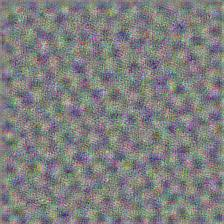

In [32]:
render_naive(layer_output_tensor(layer)[:,:,:,channel])


# Multiscale image generation
Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.

In [33]:
# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

In [34]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in tqdm(range(iter_n)):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            
        clear_output()
        showarray(normalize_image(img))

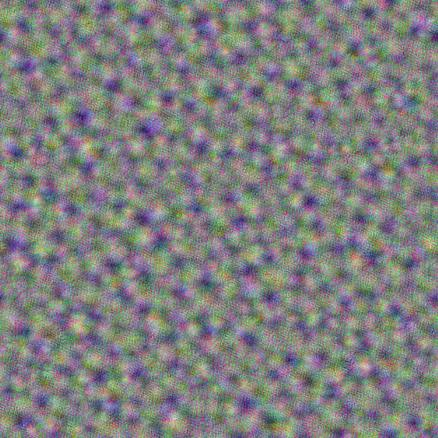

In [35]:
render_multiscale(layer_output_tensor(layer)[:,:,:,channel])

In [36]:
def render_deepdream(t_obj, img0=img_noise, iter_n=100, step=1.5, octave_n=4, octave_scale=1.4):
    
    
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in tqdm(range(iter_n)):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            
        clear_output()
        showarray(img/255.0)
    save_image(img, 'output/outputclock1.jpg')
    print('DeepDream image finished generating!!')

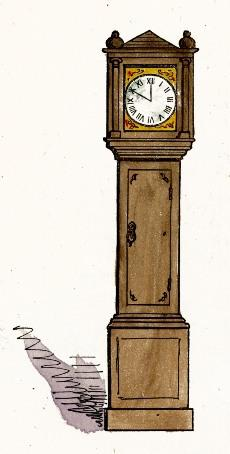

In [37]:
img0 = PIL.Image.open('images/clock.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

## Test 

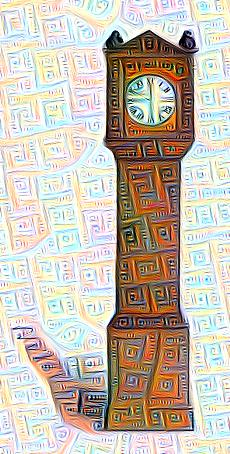

DeepDream image finished generating!!


In [38]:
render_deepdream(tf.square(layer_output_tensor('mixed3a')), img0) 